 # Importing Required libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import random
from PIL import Image
import plotly.graph_objects as go
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


# Extracting the datasets

In [ ]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

# Setting up paths

In [ ]:
train_dir = '/kaggle/working/train/train'
test_dir = '/kaggle/working/test/test1'

# Function to load and preprocess the images

In [ ]:
def load_images(folder, img_size=(64, 64), sample_count=20, label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)

    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]

    random.shuffle(filenames)
    for img in filenames[:sample_count]:
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0  # Normalize pixel values
            images.append(img_np)
            labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")

    return np.array(images), np.array(labels)

# Visualize images with labels

In [ ]:
def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()

    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Load and visualize cat images

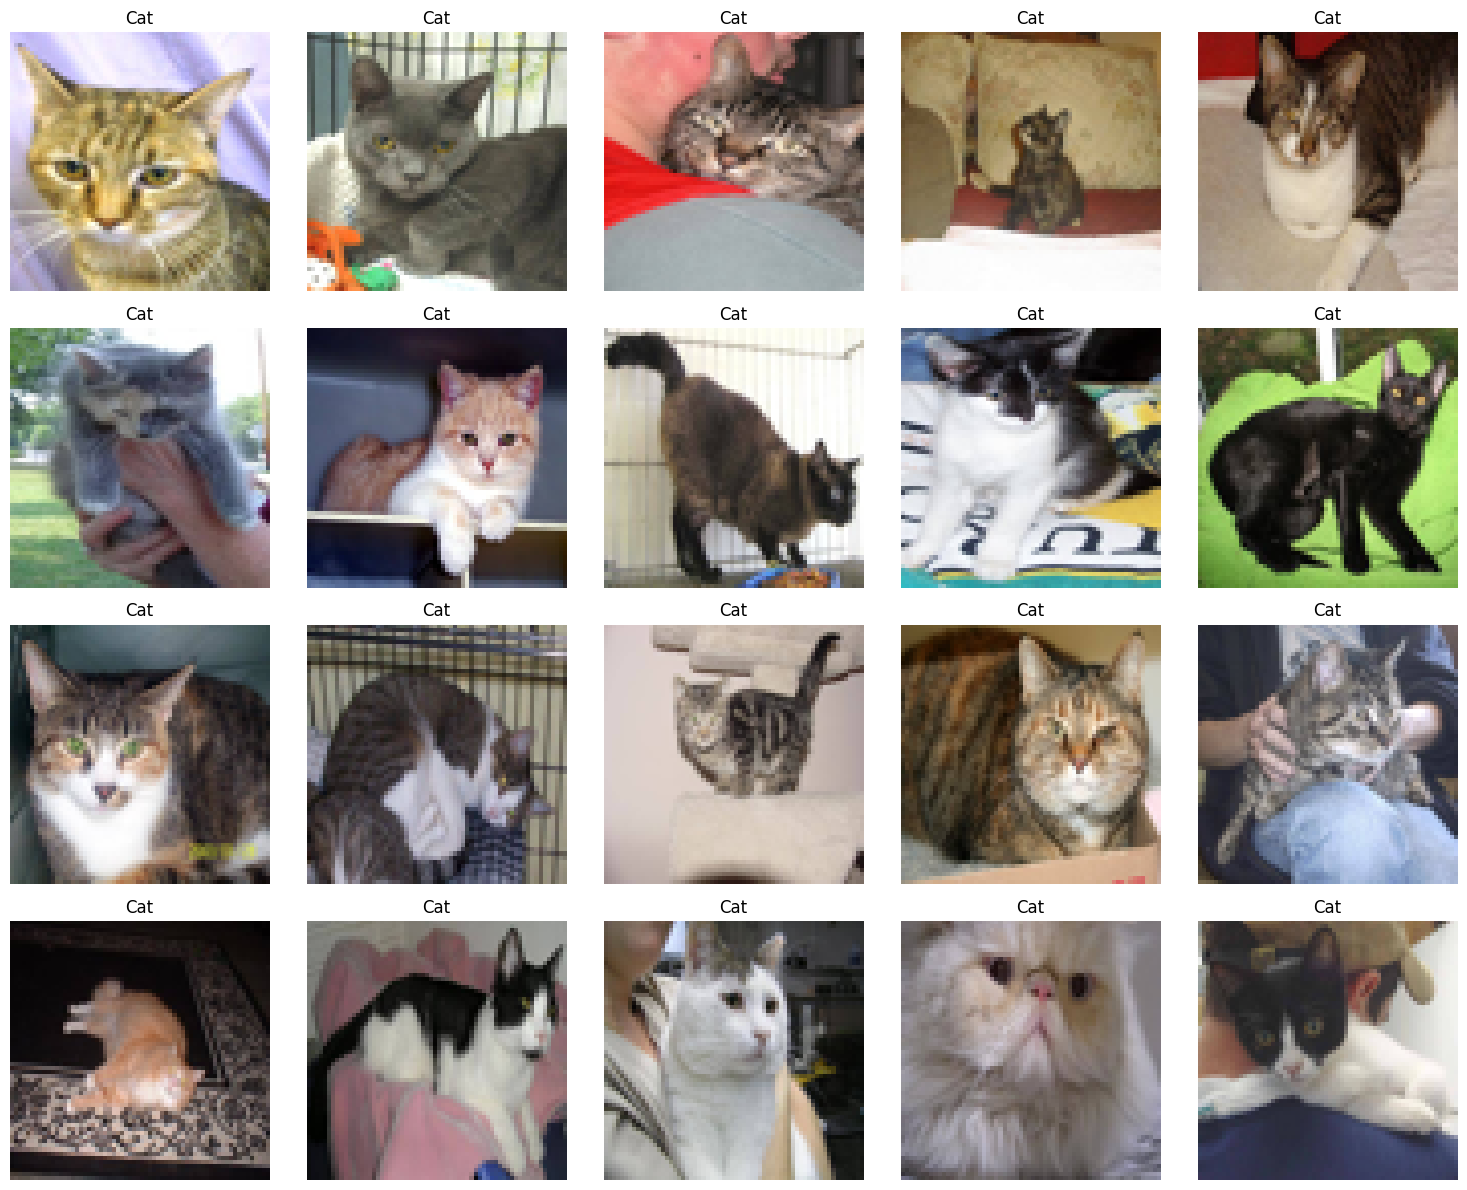

In [ ]:
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images, cat_labels, sample_count=20)

# Load and visualize dog images

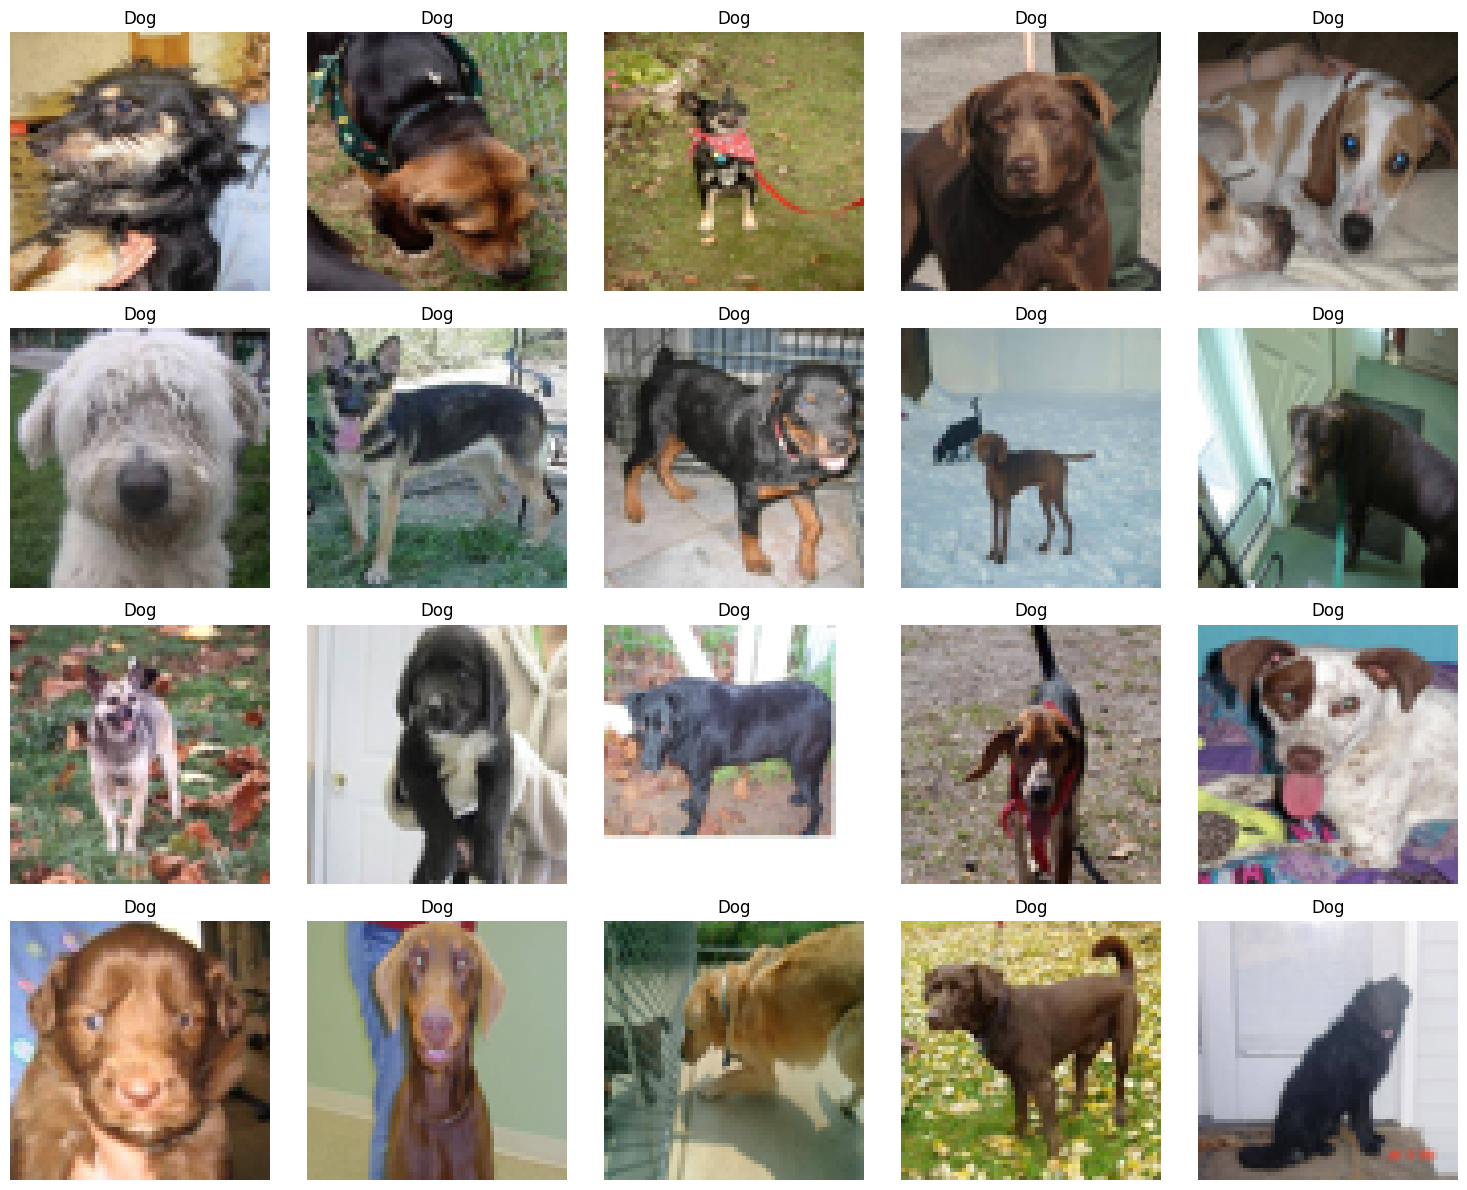

In [ ]:
dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

# Load and visualize both cat and dog images

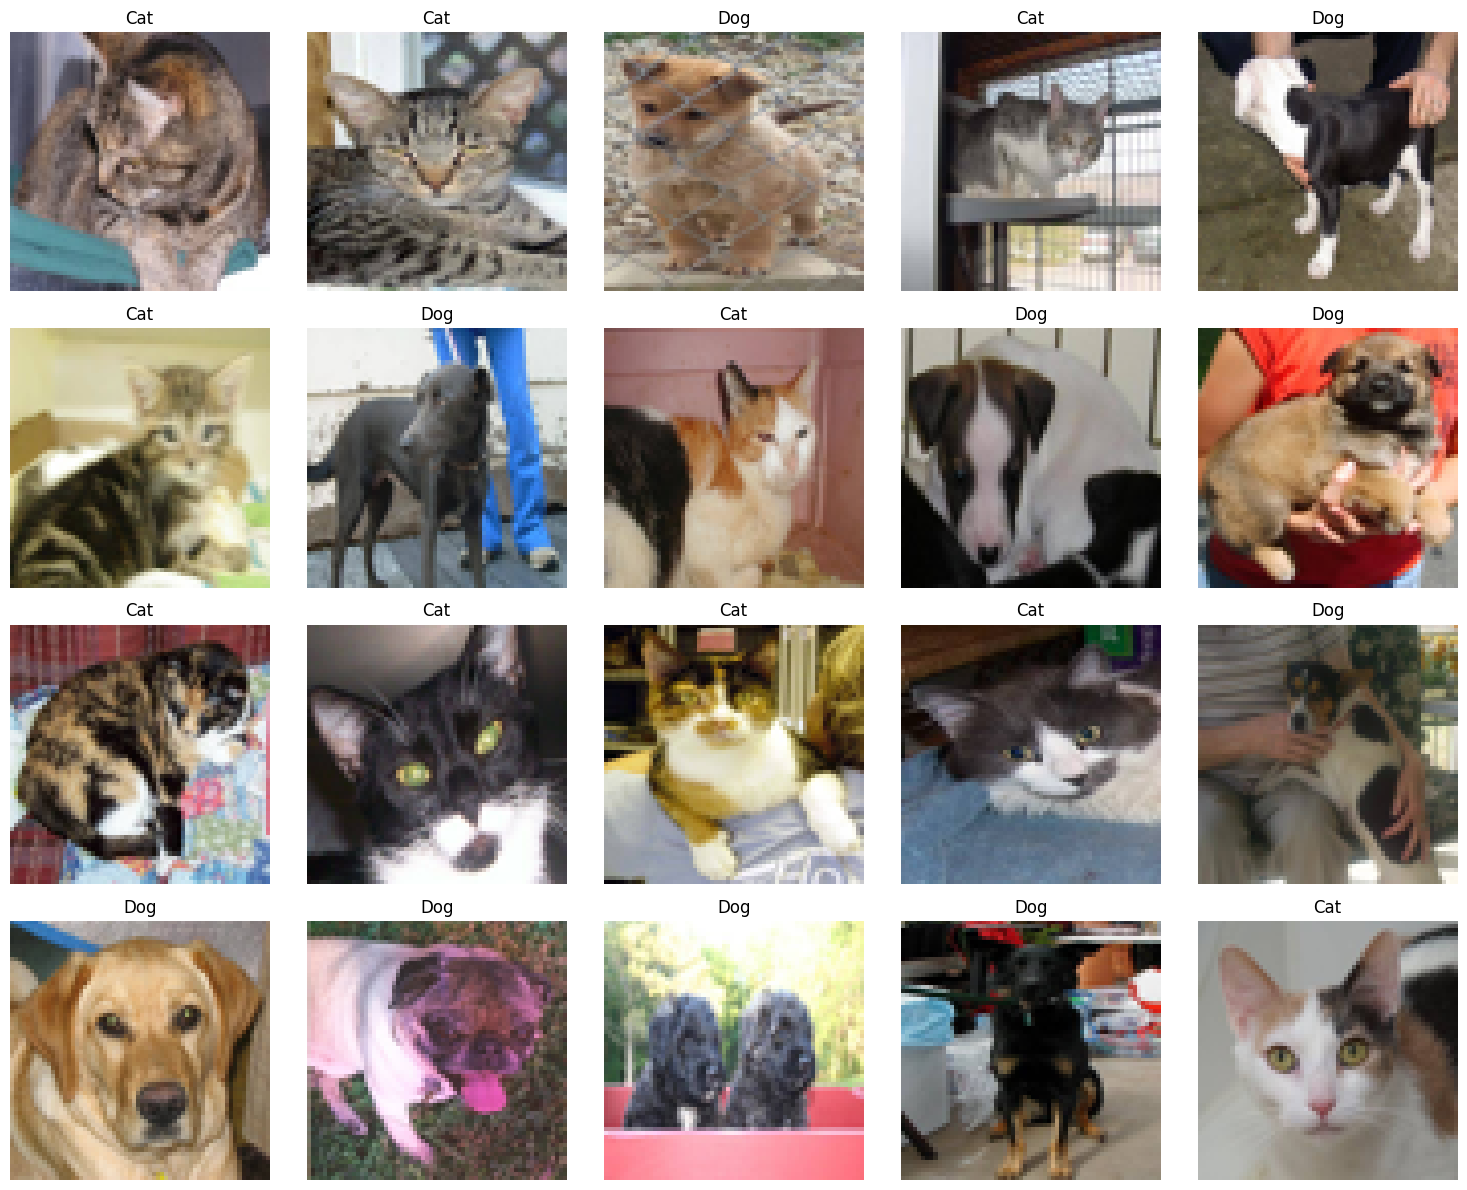

In [ ]:
all_images, all_labels = load_images(train_dir, sample_count=20)
visualize_images(all_images, all_labels, sample_count=20)

# Loading and preprocessing the training data

In [ ]:
images, labels = load_images(train_dir, sample_count=10000)
images = images / 255.0

# Display the shape of the images array

In [ ]:
print("Shape of images array:", images.shape)

Shape of images array: (10000, 64, 64, 3)


# Display the shape of the first image

In [ ]:
print("Shape of the first image:", images[0].shape)

Shape of the first image: (64, 64, 3)


 # Display the first 2 images

In [ ]:
print(images[:2])
print(labels[:2])

[[[[0.0014456  0.00129181 0.00113802]
   [0.00143022 0.00127643 0.00112265]
   [0.00141484 0.00126105 0.00110727]
   ...
   [0.00133795 0.00119954 0.00106113]
   [0.00135333 0.00121492 0.00107651]
   [0.00135333 0.00121492 0.00107651]]

  [[0.00143022 0.00127643 0.00112265]
   [0.0014456  0.00129181 0.00113802]
   [0.0014456  0.00129181 0.00113802]
   ...
   [0.0013687  0.00121492 0.00109189]
   [0.00135333 0.00121492 0.00107651]
   [0.00135333 0.00121492 0.00107651]]

  [[0.00143022 0.00127643 0.00112265]
   [0.0014456  0.00129181 0.00113802]
   [0.0014456  0.00129181 0.00113802]
   ...
   [0.0013687  0.0012303  0.00109189]
   [0.00135333 0.00121492 0.00107651]
   [0.0013687  0.0012303  0.00109189]]

  ...

  [[0.0002922  0.00027682 0.00039985]
   [0.00038447 0.00036909 0.00049212]
   [0.00041522 0.00035371 0.00049212]
   ...
   [0.00164552 0.00143022 0.00121492]
   [0.00163014 0.00141484 0.00121492]
   [0.00164552 0.00141484 0.00118416]]

  [[0.00019992 0.00016917 0.0002922 ]
   [0.0

# Flattening the images for the SVM input

In [ ]:
n_samples, img_height, img_width, img_channels = images.shape
images_flat = images.reshape(n_samples, -1)

# Standardizing the features

In [ ]:
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

# Applying t-SNE

In [ ]:
perplexity = min(30, n_samples - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
images_tsne = tsne.fit_transform(images_flat_scaled)

# Splitting the dataset into training and test sets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images_flat_scaled, labels, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[-0.69025085, -0.47320654, -0.61765727, ..., -0.73579164,
        -0.66726351, -0.4442787 ],
       [ 1.22405703,  1.52248835,  0.46600382, ..., -1.25270462,
        -1.26968399, -1.24947355],
       [-0.57596381, -0.48756405, -0.53321614, ...,  0.25372747,
        -0.36605327, -0.41499889],
       ...,
       [ 0.36690425,  0.28774187,  0.26897453, ..., -1.69577288,
        -1.36004706, -0.94203552],
       [ 1.63834754,  1.85271125,  1.78891476, ...,  1.09555716,
         1.13999792,  0.53659502],
       [ 1.16691351,  1.3932707 ,  1.39485618, ...,  0.15034488,
         0.22130669, -0.07828104]])

In [ ]:
X_val

array([[-0.36167562, -0.97571964, -1.33540682, ...,  0.68202679,
         0.25142772, -0.10756086],
       [-0.4473909 , -0.0281235 ,  0.12823933, ..., -1.42993192,
        -1.1642604 , -1.41051252],
       [-1.46168836, -1.40644515, -1.15245105, ...,  0.23895853,
         0.55263795,  0.7122739 ],
       ...,
       [ 0.72405124,  0.77589746,  0.8600624 , ..., -0.80963635,
        -0.83292914, -0.56139795],
       [ 0.8240524 ,  0.61796477, -0.30803981, ...,  1.13986399,
         1.09481638,  0.2437969 ],
       [ 0.79548064,  0.73282491,  0.64895959, ...,  0.51956843,
         0.37191181,  0.31699643]])

In [ ]:
X_val

array([[-0.36167562, -0.97571964, -1.33540682, ...,  0.68202679,
         0.25142772, -0.10756086],
       [-0.4473909 , -0.0281235 ,  0.12823933, ..., -1.42993192,
        -1.1642604 , -1.41051252],
       [-1.46168836, -1.40644515, -1.15245105, ...,  0.23895853,
         0.55263795,  0.7122739 ],
       ...,
       [ 0.72405124,  0.77589746,  0.8600624 , ..., -0.80963635,
        -0.83292914, -0.56139795],
       [ 0.8240524 ,  0.61796477, -0.30803981, ...,  1.13986399,
         1.09481638,  0.2437969 ],
       [ 0.79548064,  0.73282491,  0.64895959, ...,  0.51956843,
         0.37191181,  0.31699643]])

In [ ]:
y_val

array([1, 1, 1, ..., 0, 0, 1])

# Checking class distribution

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 5019, 1: 4981}


In [ ]:
def plot_tsne_data(tsne_data, labels, title):
    df_tsne = pd.DataFrame()
    df_tsne['X'] = tsne_data[:, 0]
    df_tsne['Y'] = tsne_data[:, 1]
    df_tsne['Label'] = labels
    df_tsne['Label'] = df_tsne['Label'].map({0: 'Cat', 1: 'Dog'})

    fig = px.scatter(df_tsne, x='X', y='Y', color='Label', title=title)
    fig.show()

plot_tsne_data(images_tsne, labels, 't-SNE visualization of Cats vs Dogs')

# Training the SVM model

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

KeyboardInterrupt: 

# Making predictions on the validation set

In [ ]:
y_val_pred = svm.predict(X_val)

In [ ]:
y_val_pred

# Evaluating the model

In [ ]:
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Accuracy

In [ ]:
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Classification Report

In [ ]:
print('Validation Classification Report:')
print(val_class_report)

# Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
print('Validation Confusion Matrix:')
print(val_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()


# Saving the SVM model and scaler

In [ ]:
import pickle
with open('/kaggle/working/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('/kaggle/working/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Loading and preprocessing the test data

In [ ]:
test_images, test_labels = load_images(test_dir)
test_images = test_images / 255.0

# Flattening the test images for the SVM input

In [ ]:
n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
test_images_flat = test_images.reshape(n_test_samples, -1)
test_images_flat_scaled = scaler.transform(test_images_flat)

# Standardizing the test features

In [ ]:
test_images_flat_scaled = scaler.transform(test_images_flat)

# Applying t-SNE for visualization on test data

In [ ]:
# Determine a new perplexity value for the test data
test_perplexity = min(30, n_test_samples - 1)

# Create a new t-SNE instance for the test data
test_tsne = TSNE(n_components=2, perplexity=test_perplexity, random_state=42)
test_images_tsne = test_tsne.fit_transform(test_images_flat_scaled)

# Making predictions on the test set

In [ ]:
y_test_pred = svm.predict(test_images_flat_scaled)

In [ ]:
y_test_pred

# Creating a DataFrame for Plotly

In [ ]:
df_test_tsne = pd.DataFrame()
df_test_tsne['X'] = test_images_tsne[:, 0]
df_test_tsne['Y'] = test_images_tsne[:, 1]
df_test_tsne['Predicted Label'] = y_test_pred
df_test_tsne['Predicted Label'] = df_test_tsne['Predicted Label'].map({0: 'Cat', 1: 'Dog'})


# Plotting with Plotly

In [ ]:
fig = px.scatter(df_test_tsne, x='X', y='Y', color='Predicted Label', title='t-SNE visualization of Test Data Predictions')
fig.show()

# Visualizing some of the test results with Plotly

In [ ]:
def plot_test_samples(images, tsne_data, predictions, sample_count=10):
    sample_indices = np.random.choice(range(len(images)), sample_count, replace=False)
    sample_images = images[sample_indices]
    tsne_samples = tsne_data[sample_indices]
    pred_samples = predictions[sample_indices]

    fig = px.scatter(tsne_samples, x=tsne_samples[:, 0], y=tsne_samples[:, 1], color=pred_samples.astype(str),
                     title="Test Data Predictions (t-SNE Space)")
    fig.show()

plot_test_samples(test_images, test_images_tsne, y_test_pred)

# Saving the test predictions to a CSV file

In [ ]:
test_predictions = pd.DataFrame({'Id': np.arange(1, n_test_samples + 1), 'Label': y_test_pred})
test_predictions['Label'] = test_predictions['Label'].map({0: 'Cat', 1: 'Dog'})
test_predictions.to_csv('/kaggle/working/test_predictions.csv', index=False)

In [ ]:
def plot_samples(tsne_data, y_true, y_pred, sample_count=10):
    sample_indices = np.random.choice(range(len(tsne_data)), sample_count, replace=False)
    tsne_samples = tsne_data[sample_indices]
    y_true_samples = y_true[sample_indices]
    y_pred_samples = y_pred[sample_indices]

    df_tsne_samples = pd.DataFrame()
    df_tsne_samples['X'] = tsne_samples[:, 0]
    df_tsne_samples['Y'] = tsne_samples[:, 1]
    df_tsne_samples['True Label'] = y_true_samples
    df_tsne_samples['Predicted Label'] = y_pred_samples
    df_tsne_samples['True Label'] = df_tsne_samples['True Label'].map({0: 'Cat', 1: 'Dog'})
    df_tsne_samples['Predicted Label'] = df_tsne_samples['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

    fig = px.scatter(df_tsne_samples, x='X', y='Y', color='True Label', symbol='Predicted Label', title="True vs Predicted Labels (t-SNE Space)")
    fig.show()

# Apply t-SNE to the validation data
val_tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
val_images_tsne = val_tsne.fit_transform(X_val)

# Plot true vs predicted labels for the validation set
plot_samples(val_images_tsne, y_val, y_val_pred)


# Thank You!